# Plot Storm Locations vs. Ensemble Mean State to Analyze Stratification Across Gradients

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Fig. 16

In [8]:
#######################################################################################
#                                                                                     #
#         Creates 2-panel plot for upper and lower tercile storm tracks over          #
#       ground-relative ensemble mean 2m temp and subset mean difference 2m temp.     #
#                     Used for figures in Faletti et al. (2024).                      #
#                                                                                     #
#######################################################################################

import numpy as np
import xarray as xr
import pandas as pd
import glob
import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.patheffects as pe
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import centered_response as cr
from wofunits import wofunits

import logging

# define confidence ellipse function
def confidence_ellipse(x,y, stdevs=2.0):
    cov = np.cov(x,y)
    val, rot = np.linalg.eig(cov)
    val = np.sqrt(val)
    center = np.mean([x, y], axis=1)[:, None]
    
    t = np.linspace(0, 2.0 * np.pi, 1000)
    xy = np.stack((np.cos(t), np.sin(t)), axis=-1)
    
    ellipse = (stdevs * rot @ (val * xy).T + center)
    
    return ellipse

## Manually set case, time, etc. for the desired plotting

In [9]:
# save plot?
save = False

# select case
#case='201905172100'
#case = '201905172200'
#case = '201905262000'
case = '201905282230'


# set paths
wofsdir = wofunits.paths['wofs_path'] # WoFS data path
outplot_path = wofunits.paths['outplot_path'] # path to save plots
wofs_locs_path = wofunits.paths['wofs_locs_path'] # path to modeled storm center gridpoints
mrms_locs_path = wofunits.paths['mrms_locs_path'] # path to MRMS observed storm center gridpoints


# set sensitivity and plotting specs

var = 'T2' # state variable
respvar = 'UH25-30MIN' # response variable
levels = np.arange(286,294.1,0.5) # contourfill levels
lead_time = 0

# Define specs by case
if case == '201905172200':
    state_time = datetime.datetime(2019, 5, 17, 22, 30)
    latlon_bounds = [-101.3, -98.6, 39.8, 41.7]
    vmin, vmax=291, 301
    levels = np.arange(293,299+0.5,0.5)
    cbarticks = np.arange(293,299+0.5,1)
    df_idx_ny = -22
    df_idx_nx = -21
elif case == '201905202030':
    state_time = datetime.datetime(2019,5,20,20,15)
elif case == '201905262000':
    latlon_bounds = [-103.7,-101.3,37.4,38.9]
    state_time = datetime.datetime(2019,5,26,21,30)
    df_idx_ny = 0
    df_idx_nx = 1
elif case == '201905282230':
    state_time = datetime.datetime(2019,5,29,1,0)
    latlon_bounds = [-98.5,-96.2,39.2,40.8]
    vmin, vmax=286, 294
    levels = np.arange(286,294+0.0001,0.5)
    cbarticks = np.arange(286,294+0.0001,1)
    df_idx_ny = -22
    df_idx_nx = -21

# set axis labels
axlabels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

## Process data with chosen specs

In [10]:
_, _, _, _, _, _, _, resptime = cr.case_sel(case)

# calculate lead time
resptime = datetime.datetime.strptime(resptime, '%Y-%m-%d_%H_%M_%S')
lead_time = int((resptime - state_time).total_seconds() / 60)
valid_time_idx = -int((lead_time / 15) + 2)

    # define PBL scheme indices
ysu_idx = wofunits.schemeidx['ysu']
myj_idx = wofunits.schemeidx['myj']
mynn_idx = wofunits.schemeidx['mynn']

ranklist = wofunits.rankidx[case][respvar]

# define mapping variables
shapefiles = wofunits.mapping['shapefiles']
shp_cols = wofunits.mapping['edgecolor']
shp_lws = wofunits.mapping['lw']

file_wofs = f'{wofsdir}/wofs_{case[:8]}_{case[8:]}/wofs_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'
ds_wofs = xr.open_dataset(file_wofs)

In [11]:
#%%capture --no-stdout

# Manipulate pandas dataframe from csv to proper format that separates ny and ny coordinates into separate columns

if case == '201905172200':
    df_center = pd.read_csv(f'{wofs_locs_path}/max_gridpoint_storm_centering_{case}.csv',
                   header=0)
elif case == '201905262000':
    df_center = pd.read_csv(f'{wofs_locs_path}/max_gridpoint_storm_centering_{case[:8]}.csv',
                   header=0).iloc[:,:-3]
else:
    df_center = pd.read_csv(f'{wofs_locs_path}/max_gridpoint_storm_centering_{case[:8]}.csv',
                   header=0)

ds_maxima_mrms = xr.open_dataset(f'{mrms_locs_path}/mrms_maxima_indices_{case[5:8]}')

valid_times = df_center.columns.values.tolist()[1:]

df_center = df_center.rename(columns={'Unnamed: 0': 'Member'}).set_index('Member')

logging.captureWarnings(True) # capture warnings
for i in range(len(valid_times)):
    col = df_center.iloc[:,i].str.replace('(', '').str.replace(')', '', regex=False)
    col = col.apply(lambda x: pd.Series(str(x).split(',')))
    col = col.rename(columns={0:f'{valid_times[i]} nx',
                              1:f'{valid_times[i]} ny'})
    
    df_center = pd.merge(df_center, col, on='Member')
logging.captureWarnings(False) # turn warnings back on

df_center = df_center.iloc[:,len(valid_times):].astype(int)

if case == '201905262000':
    df_nx = df_center.iloc[:,1::2] + ds_maxima_mrms.attrs['EW_displacement']
    df_ny = df_center.iloc[:,0::2] + ds_maxima_mrms.attrs['NS_displacement']
else:
    df_nx = df_center.iloc[:,1::2] + ds_maxima_mrms.attrs['EW_displacement']
    df_ny = df_center.iloc[:,0::2] + ds_maxima_mrms.attrs['NS_displacement']


df_center = pd.concat([df_ny, df_nx], axis=1)
df_center = df_center[list(sum(zip(df_ny.columns, df_nx.columns), ()))]

#df_center

## Plot Fig. 16: Upper- vs. Lower-Tercile Storm Positions 
### (Generated top and bottom half separately with this code)

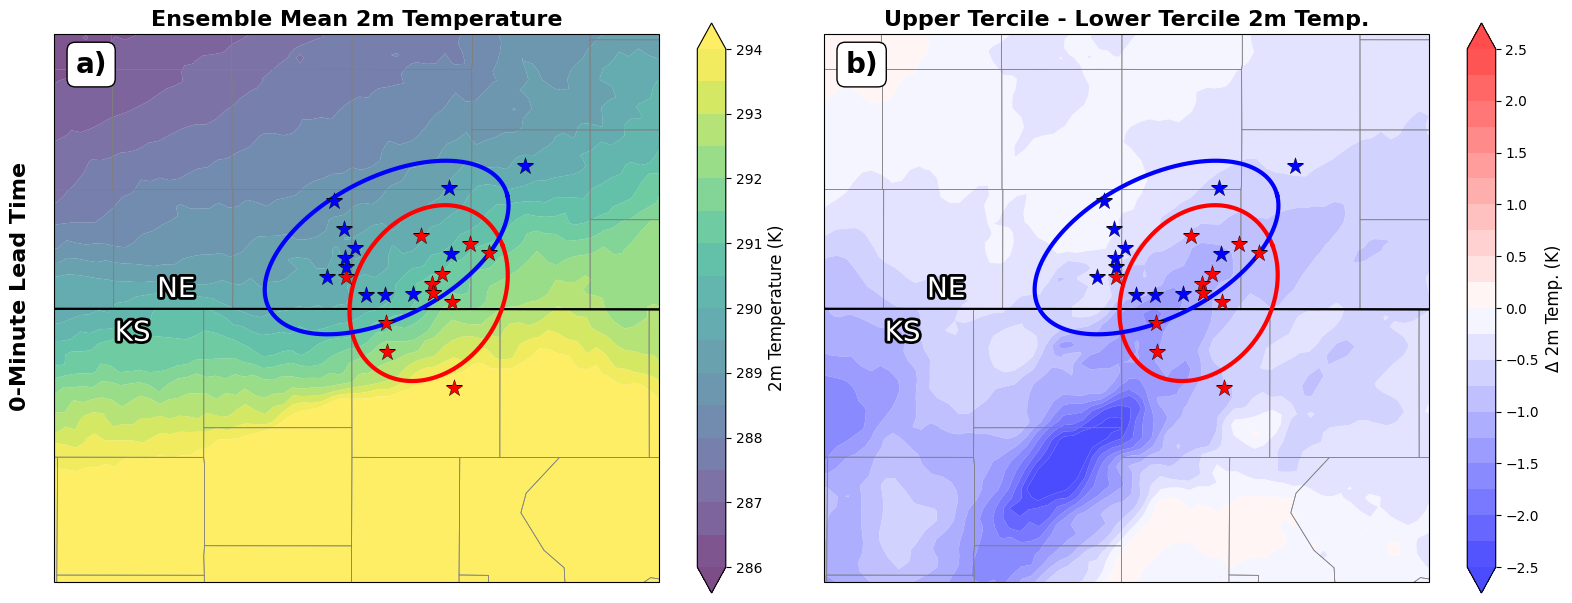

In [12]:

fig, axs = plt.subplots(
    1, 2, figsize=(16, 6),
    subplot_kw={'projection': ccrs.Mercator()}
)

ax1, ax2 = axs


# Process and pull remaining data
lat, lon = ds_wofs.XLAT.values[0,0], ds_wofs.XLONG.values[0,0]
cref = np.nanmean(ds_wofs['REFD_MAX'].values, axis=(0,1)) 

temp_upp = np.nanmean(ds_wofs[var].values[ranklist[:12]], axis=(0,1)) 
temp_low = np.nanmean(ds_wofs[var].values[ranklist[25:]], axis=(0,1))

smd = temp_upp - temp_low
mean_t_upp = np.nanmean(ds_wofs[var].values[ranklist[25:]], axis=(0,1))

# Begin plotting on axes
for j, ax in enumerate([ax1,ax2]):
    
    ax.text(0.035, 0.93, axlabels[j], color='k',
        bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax.transAxes, 
        size=20, weight='bold')
    
    colors = ['r','b']
    for i, terc in enumerate([ranklist[:12],ranklist[24:]]):
        ax.scatter(lon[df_center.iloc[terc,df_idx_ny::2].values[:,valid_time_idx], df_center.iloc[terc,df_idx_nx::2].values[:,valid_time_idx]],
            lat[df_center.iloc[terc,df_idx_ny::2].values[:,valid_time_idx], df_center.iloc[terc,df_idx_nx::2].values[:,valid_time_idx]], 
                   marker='*', s=160, c=colors[i], edgecolor='k', lw=0.3, transform=ccrs.PlateCarree(), zorder=10000)
        
            # draw confidence ellipses around PBL scheme scatter locations
        x = lon[df_center.iloc[terc,df_idx_ny::2].values[:,valid_time_idx], df_center.iloc[terc,df_idx_nx::2].values[:,valid_time_idx]]
        y = lat[df_center.iloc[terc,df_idx_ny::2].values[:,valid_time_idx], df_center.iloc[terc,df_idx_nx::2].values[:,valid_time_idx]]
        
        ellipse = confidence_ellipse(x,y)
        
        ax.plot(*ellipse, c=colors[i], lw=3, transform=ccrs.PlateCarree(), zorder=1000)
        

ax1.text(-0.04, 0.54, '0-Minute Lead Time', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', size=16, weight='bold',
        transform=ax1.transAxes)
        
cb = ax1.contourf(lon, lat, mean_t_upp, transform=ccrs.PlateCarree(),levels=levels,
                     cmap='viridis', extend='both', alpha=0.7,
                     antialiased=True)

cbar = plt.colorbar(cb, ax=ax1)
cbar.set_label(label='2m Temperature (K)', size=12)

cb = ax2.contourf(lon, lat, smd, transform=ccrs.PlateCarree(),
                     cmap='bwr', extend='both', levels=np.arange(-2.5,2.5001,0.25),
                     alpha=0.7, antialiased=True)

cbar = plt.colorbar(cb, ax=ax2, ticks=np.arange(-2.5,2.500001,0.5))
cbar.set_label(label='Δ 2m Temp. (K)', size=12)

for ax in [ax1,ax2]:
    for j in range(len(shapefiles)):
        reader = shpreader.Reader(shapefiles[j])
        vector_data = list(reader.geometries()) 
        VECTOR_DATA = cfeature.ShapelyFeature(vector_data, ccrs.PlateCarree())
        ax.add_feature(VECTOR_DATA, facecolor='none', edgecolor = shp_cols[j], lw = shp_lws[j])

    ax.set_extent(latlon_bounds, crs=ccrs.PlateCarree())
    

    if case == '201905172200':
        ax.text(0.25, 0.045, 'KS', transform=ax.transAxes, size=20, color='w',
                  path_effects=[pe.withStroke(linewidth=4, foreground='k')])
        ax.text(0.32, 0.13, 'NE', transform=ax.transAxes, size=20, color='w',
                  path_effects=[pe.withStroke(linewidth=4, foreground='k')])
    if case == '201905282230':
        ax.text(0.10, 0.44, 'KS', transform=ax.transAxes, size=20, color='w',
                  path_effects=[pe.withStroke(linewidth=4, foreground='k')])
        ax.text(0.17, 0.52, 'NE', transform=ax.transAxes, size=20, color='w',
                  path_effects=[pe.withStroke(linewidth=4, foreground='k')])
    

    # convoluted legend stuff
red_patch = mpatches.Patch(color='red', label='Upper tercile') 
blue_patch = mpatches.Patch(color='blue', label='Lower tercile')
black_star = mlines.Line2D([], [], color='k', marker='*', linestyle='None', markersize=12, label='Storm Position')


ax1.set_title('Ensemble Mean 2m Temperature', size=16, weight='bold')
ax2.set_title('Upper Tercile - Lower Tercile 2m Temp.', size=16, weight='bold')

plt.tight_layout()

if save == True:
    plt.savefig(fname=f'{outplot_path}/ellipse_tercile_compare_{case}_bot.png', dpi=300, bbox_inches='tight', facecolor='w')


### Plots storm tracks over ensemble max UH 

ds_wofs_resp = xr.open_dataset(f'{wofsdir}/wofs_20190517_2200/wofs_i201905172200_v201905180030.nc')

#

fig,ax = plt.subplots(1, 1, figsize=(10,8))

ax = plt.subplot(1,1,1,projection=ccrs.Mercator(), aspect='auto')

cb = plt.contourf(lon, lat, np.nanmax(ds_wofs_resp['UH_30SWT25_WRF'], axis=(0,1)), levels=np.arange(25,301,25),
             cmap='plasma', extend='max', transform=ccrs.PlateCarree())

for mem in range(len(df_center)-1):
    ax.plot(lon[df_center.iloc[mem,-8::2].values[:-1], df_center.iloc[mem,-7::2].values[:-1]], 
                    lat[df_center.iloc[mem,-8::2].values[:-1], df_center.iloc[mem,-7::2].values[:-1]], 
                    transform=ccrs.PlateCarree(), lw=3, ls='--',alpha=0.8, c='k')
    
    
    
for j in range(len(shapefiles)):
    reader = shpreader.Reader(shapefiles[j])
    vector_data = list(reader.geometries()) 
    VECTOR_DATA = cfeature.ShapelyFeature(vector_data, ccrs.PlateCarree())
    ax.add_feature(VECTOR_DATA, facecolor='none', edgecolor = edgecolor[j], lw = lw[j])

ax.set_extent(latlon_bounds, crs=ccrs.PlateCarree())

black_line = mlines.Line2D([], [], color='k', linestyle='-', label='Storm tracks during response window')

cbar = plt.colorbar(cb, ax=ax, ticks=np.arange(25,301,25))
cbar.set_label(label=f'2-5km Updraft Helicity ({wofunits.labels[respvar]})', size=12)

plt.title('Storm Tracks and UH During Response Window', size=16, weight='bold')

## Same as Fig. 16 but for storm positions by PBL scheme

/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_6613/1661314837.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


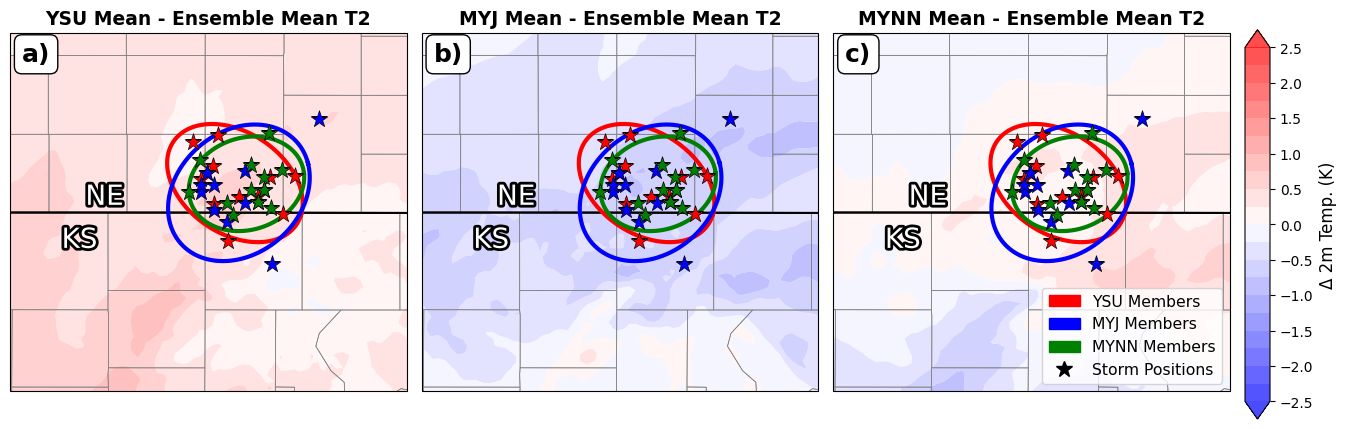

In [13]:

ysu_var = np.nanmean(ds_wofs[var].values[ysu_idx], axis=(0,1))
myj_var = np.nanmean(ds_wofs[var].values[myj_idx], axis=(0,1))
mynn_var = np.nanmean(ds_wofs[var].values[mynn_idx], axis=(0,1))
mean_var = np.nanmean(ds_wofs[var].values[:], axis=(0,1))

ysu_diff = ysu_var - mean_var
myj_diff = myj_var - mean_var
mynn_diff = mynn_var - mean_var

fig, axs = plt.subplots(
    1, 3, figsize=(12.5, 4.5),
    subplot_kw={'projection': ccrs.Mercator()}
)

ax1,ax2,ax3 = axs

axes = [ax1, ax2, ax3]

valid_time_idx = -int((lead_time / 15) + 2)

for ax in axes:
    
    colors = ['r','b','g']
    for i, scheme_idx in enumerate([ysu_idx, myj_idx, mynn_idx]):

        ax.scatter(lon[df_center.iloc[scheme_idx,-22::2].values[:,valid_time_idx], df_center.iloc[scheme_idx,-21::2].values[:,valid_time_idx]],
               lat[df_center.iloc[scheme_idx,-22::2].values[:,valid_time_idx], df_center.iloc[scheme_idx,-21::2].values[:,valid_time_idx]], 
                   c=colors[i], marker='*', edgecolor='k', lw=0.5,s=160, 
                   transform=ccrs.PlateCarree(), zorder=991)
            
            # draw confidence ellipses around PBL scheme scatter locations
        x = lon[df_center.iloc[scheme_idx,-22::2].values[:,valid_time_idx], df_center.iloc[scheme_idx,-21::2].values[:,valid_time_idx]]
        y = lat[df_center.iloc[scheme_idx,-22::2].values[:,valid_time_idx], df_center.iloc[scheme_idx,-21::2].values[:,valid_time_idx]]
        
        ellipse = confidence_ellipse(x,y)
        
        ax.plot(*ellipse, c=colors[i], lw=3, transform=ccrs.PlateCarree())

cb = ax1.contourf(lon, lat, ysu_diff, transform=ccrs.PlateCarree(),
                     cmap='bwr', extend='both', levels=np.arange(-2.5,2.5001,0.25), 
                      alpha=0.7, antialiased=True)

cb = ax2.contourf(lon, lat, myj_diff, transform=ccrs.PlateCarree(),
                     cmap='bwr', extend='both', levels=np.arange(-2.5,2.5001,0.25), 
                      alpha=0.7, antialiased=True)

cb = ax3.contourf(lon, lat, mynn_diff, transform=ccrs.PlateCarree(),
                     cmap='bwr', extend='both', levels=np.arange(-2.5,2.5001,0.25), 
                      alpha=0.7, antialiased=True)

for i, ax in enumerate(axes):
    for j in range(len(shapefiles)):
        reader = shpreader.Reader(shapefiles[j])
        vector_data = list(reader.geometries()) 
        VECTOR_DATA = cfeature.ShapelyFeature(vector_data, ccrs.PlateCarree())
        ax.add_feature(VECTOR_DATA, facecolor='none', edgecolor = shp_cols[j], lw = shp_lws[j])
    
    ax.set_extent(latlon_bounds, crs=ccrs.PlateCarree())

    
    if case == '201905172200':
        ax.text(0.25, 0.03, 'KS', transform=ax.transAxes, size=20, color='w',
                  path_effects=[pe.withStroke(linewidth=4, foreground='k')])
        ax.text(0.32, 0.13, 'NE', transform=ax.transAxes, size=20, color='w',
                  path_effects=[pe.withStroke(linewidth=4, foreground='k')])
    if case == '201905282230':
        ax.text(0.13, 0.4, 'KS', transform=ax.transAxes, size=20, color='w',
                  path_effects=[pe.withStroke(linewidth=4, foreground='k')])
        ax.text(0.19, 0.52, 'NE', transform=ax.transAxes, size=20, color='w',
                  path_effects=[pe.withStroke(linewidth=4, foreground='k')])

    ax.annotate(text=axlabels[i], xy=(0.03, 0.92), bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), 
                size = 18, weight='bold', xycoords='axes fraction')
    
    # convoluted legend stuff
red_patch = mpatches.Patch(color='red', label='YSU Members') 
blue_patch = mpatches.Patch(color='blue', label='MYJ Members')
green_patch = mpatches.Patch(color='green', label='MYNN Members')
black_star = mlines.Line2D([], [], color='k', marker='*', linestyle='None', markersize=12, label='Storm Positions')

ax3.legend(handles=[red_patch,blue_patch,green_patch,black_star], loc='lower right', fontsize=11.25) 

ax1.set_title(f'YSU Mean - Ensemble Mean {var}', size=13.5, weight='bold')
ax2.set_title(f'MYJ Mean - Ensemble Mean {var}', size=13.5, weight='bold')
ax3.set_title(f'MYNN Mean - Ensemble Mean {var}', size=13.5, weight='bold')


# colorbar
fig.subplots_adjust(0, 0, 0.8, 1)
cb_ax = fig.add_axes([1, 0.04, 0.02, 0.865])
cbar = fig.colorbar(cb, cax=cb_ax, ticks=np.arange(-2.5,2.500001,0.5))
cbar.set_label(label='Δ 2m Temp. (K)', size=12)

plt.tight_layout()

#if save == True:
#    plt.savefig(fname=f'../paper_figures/ellipse_pbl_compare_{case}.png', dpi=300, bbox_inches='tight', facecolor='w')

